# Minhash for recommendations

In the [previous notebook](04-minhash.ipynb) we saw how Minhash can be used to approximate the similarity of sets. In this notebook we will see that Minhash can also be used to make recommendations. 

We illustrate this technique using a data set which contains users' listening history from a music streaming service. If you're interested in how we generated this data, take a look at [this notebook](99a-data-generator.ipynb). 

In [1]:
import os
import pandas as pd

path = 'data/' 
files = os.listdir(path)
files_data = [i for i in files if i.startswith('userdat')][0:1] #listing all files in the directory of the correct form
df = pd.DataFrame(columns=['user', 'artist','plays'])
for j in files_data:
    pseudo_data = pd.read_parquet('data/'+j)
    df = pd.concat([df, pseudo_data])
    print(df.shape)

(2593050, 3)


The data contains three columns and over three million rows. Let's take a closer look at a sample of the data. 

In [2]:
df.sample(10, random_state=1)

,user,artist,plays
4163,17140,69858,3
505,18032,133660,71
186,18545,142027,61
238,15553,58412,1
2052,17129,69605,9
112,18313,91561,1
349,16952,50141,259
523,15503,136162,9
480,17444,58716,13
1640,17978,62871,2


The first column is an integer representing a user id, the second is an integer representing an artist name, and the third column is an integer indicating how many times the user listened to the artist. 

(It turns out, these are not currently stored as integers, but as strings instead. In the next cell we transform these to integers)

In [3]:
df['artist'] = df['artist'].astype('int')
df['user'] = df['user'].astype('int')

In [4]:
df.sample(10, random_state = 1)

,user,artist,plays
4163,17140,69858,3
505,18032,133660,71
186,18545,142027,61
238,15553,58412,1
2052,17129,69605,9
112,18313,91561,1
349,16952,50141,259
523,15503,136162,9
480,17444,58716,13
1640,17978,62871,2


We take one pass through the data set to identify the set of unique users and the set of unique artists. 

In [5]:
artists = df['artist'].unique()
users = df['user'].unique()

In [6]:
print("There are ", len(artists), " artists and ", len(users), " users in our data." , sep="")

There are 29356 artists and 3100 users in our data.


We also load in a dictionary which maps from the artist integers to artist names. 

In [7]:
import pickle
file = open("data/dartists.pkl","rb")
dartists = pickle.load(file)

We want to convert the integers representing artist names back into artist names, using the dictionary. 

We group the data set by user. From there we can see which artists a particular user has listened to:

In [8]:
import numpy as np

def user_data(user, grouped_data):
    return grouped_data.get_group(user) 

def top_k_listens(listening_history, k=10):
    top_k = listening_history.sort_values(by="plays", ascending = False)["artist"].head(k).values
    return artist_names(top_k)

def artist_names(artist_ints, artist_dic = dartists):
    return [artist_dic[k] for k in artist_ints]

In [9]:
df.sample(10, random_state = 3)

,user,artist,plays
825,15877,10120,1
1347,17994,136059,4
250,16134,121788,10
377,16414,50276,1
204,16316,70471,4
1165,17147,40708,1
1858,17291,18204,1
516,16161,140950,1
568,16845,168729,1
838,18124,147402,100


In [10]:
grouped_df = df.groupby(['user'])

For a particular user we can have a look at their listening history as well as their most listened to artists. 

In [11]:
import numpy as np
u_samp = user_data(15877, grouped_df)
u_samp.sample(10)

,user,artist,plays
744,15877,45917,1
572,15877,131919,2
733,15877,136363,1
113,15877,14621,1
964,15877,91073,5
1142,15877,139915,1
28,15877,170498,2
392,15877,17261,6
1465,15877,5933,6
998,15877,43382,3


And we can use the 'top_k_listened' function to look up the k artists most listened to by a particular user:

In [12]:
top_k_listens(u_samp, 10) 

['Mikica Bojanic',
 'Nick Rowland',
 'Hollandse Kerststerren',
 'D.H.T. Featuring Edmee',
 'Samurai Sam',
 'Dipnoi',
 'Alex C. Ft Y',
 'Baby Shakes',
 'Matt Sharp',
 'David Pogue Of The New York Times']

For each user, we want to generate a minhash of their listening history. The minhash class which we used in the previous notebook has been put into its own module for ease. 

So for each user, we want to compose a list of all the artists they listened to. From there we will generate minhashes for each user, then make predictions. 

TODO Explain that we have this fast function - it works by .... (?combinng mh for artists)

(this is a min hash with 128 rows)

In [13]:
from datasketching.minhash import generate_minhashes_for
from datasketching.minhash import LSHMinhash

In [14]:
mh_structs = LSHMinhash(32, 4)
minhashes = generate_minhashes_for(grouped_df, "user", "artist", mh_structs)

In [15]:
print(len(minhashes))
minhashes[0][1] ## this is a minhash object. 

3100


We can compare minhash signatures with the 'similarity' function. This returns a number between 0 and 1 where a 1 denotes identical signatures, and a 0 means that no corresponding buckets of the min hash signatures hold the same value. 

In [16]:
minhashes[2][1].similarity(minhashes[1][1])

0.7421875

In [17]:
sim = []
for i in range(len(minhashes)):
    sim.append(minhashes[1][1].similarity(minhashes[i][1]))
    
similar = set(sorted(sim, reverse = True)[1:10])
similar_users = ([i for i, e in enumerate(sim) if e in similar])
for j in similar_users:
    print(users[j])

15503
15516
15522
15524
15532
15537
15539
15540
15542
15548


These are the most similar users. Let's go ahead and look at the top artists listened to by all these users. 

Going to look at the unique artists listened to by each of these, remove uniques listened to by user 2, and then return the most listened across the other users. 

Look at the ?top 10 artists most listened to by these users that our user didnt listen to. 

In [18]:
unheard = []
for u in similar_users:
    u_dat = user_data(users[u], grouped_df)
    unheard = unheard + list(top_k_listens(u_dat, 2))

In [19]:
unheard

['(Congo) Ombiza Charles',
 'Foreign Beggars Vs Rouge À Lèvres',
 'Jimmy Martin',
 'Radius System',
 'Sc 1)',
 'Henry Badowski',
 'Alexis Taylor',
 'Eminem & Marilyn Manson',
 'Oreiro',
 'Sin 34',
 'Atomic Forest',
 'Pavor',
 'Dachshund',
 'Midge Ure & Kate Bush',
 'Eli Roth & Michael Bacall',
 'Haloblack',
 'Thompson, Judd & Wright',
 'Grad_U',
 'Magnum',
 'Alejandro Sanz Featuring Shakira']

So that's just a quick example of how we can use minhash to identify songs we should recommend to a particular user. This method works fine on a small number of users, but falls into dificulty when the number of users grows, and the number of users for which we want to make recommendations for grows. 

Let's plot the time required to compare users:

In [20]:
import time
npairs = [10, 25, 50, 75, 100, 300, 500, 750, 1000, 2000, 3100]
times = []
for pairs in npairs:
    start = time.time()
    sim=[]
    for i in range(1, pairs):
        for j in range((i+1), pairs):
            sim.append(minhashes[i][1].similarity(minhashes[j][1]))
    end = time.time()
    times.append((pairs, end-start))

In [21]:
times

[(10, 0.00010895729064941406),
 (25, 0.0005309581756591797),
 (50, 0.002137899398803711),
 (75, 0.004729032516479492),
 (100, 0.00880575180053711),
 (300, 0.07836794853210449),
 (500, 0.23706579208374023),
 (750, 0.49386096000671387),
 (1000, 0.86287522315979),
 (2000, 3.634202003479004),
 (3100, 8.452794790267944)]

/anaconda2/envs/composable-recs/lib/python3.6/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


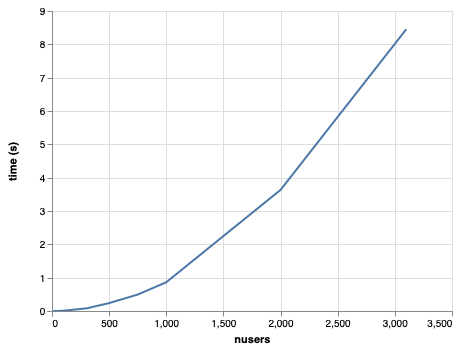

In [22]:
import altair as alt

times_df = pd.DataFrame.from_records(times)
times_df.rename(columns = {0:"nusers", 1:"time (s)"}, inplace = True)
alt.renderers.enable('notebook')
alt.Chart(times_df). mark_line().encode(x="nusers", y="time (s)")

## Locality-Sensitive Minhash

As the graph above shows, one big disadvantage of using Minhash signatures to identify similar users is the number of pairwise comparisons which must be made to determine similarity. 

Locality-sensitive Minhash is a technique we can use to identify candidate pairs of similar users for a much smaller computational cost. The method works by hashing subsets minhash signatures. If 2 users have identical signatures in ANY of the subsets these users are considered a candidate pair. And from there you can go and compute their approximate Jaccard index, or similarity, using the full minhash signatures, to determine just how similar they are, and decide if you want to make recommendations. 

The way in locality sensitive minhash works is by splitting the minhash signatures into bands. The bands are then hashed to buckets. 

if, in any band, two users map to the same bucket, they would be considered a candidate pair. At that point you’d go back and look at their minhash signatures, and compare those to determine how similar the users are. 


And thus we only have to compute the similarity of the minhash signatures for a subset of the whole population. 

In [26]:
from collections import defaultdict

bands = [defaultdict(lambda: list()) for i in range(len(lshm.lsh_keys()))]

for ind, lshm in minhashes:
    for idx, key in enumerate(lshm.lsh_keys()):
        bands[idx][key % (1 << 14)].append(ind)

We've made a dictionary of values for each band, where the keys correspond to buckets, and the values are indexes of minhash signature which mapped to that bucket. 

If two minhash signatures hash to the same key in ANY band we consider them to be 'candidate pairs'. 

This means that the corresponding users _may_ be similar. We can check if they are similar by comparing the set of artists they have each listend to. From there we can use this information to make recomendations, or move on to consider other candidate pairs. 

In [ ]:
bands